In [1]:
import math
from pathlib import Path
import numpy as np 
import matplotlib.pyplot as plt
import cv2 as cv
import torch
import torch.nn as nn
import torch.nn.functional as F


In [2]:
torch.cuda.is_available()

False

In [3]:
gt_mask = torch.ones((2, 4))
gt_mask[0, 3] = 0
gt_mask = gt_mask.unsqueeze(-1)
gt_mask = gt_mask.expand(-1, -1, 8).bool()
print(gt_mask)

tensor([[[ True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True],
         [False, False, False, False, False, False, False, False]],

        [[ True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True,  True,  True]]])


In [4]:
align_metric=torch.tensor([[[10,1,2,1,1,1,1,10],
                            [3,4,5,1,1,1,1,1],
                            [7,8,9,1,1,1,1,1],
                            [1,4,7,1,1,1,1,1]],

                            [[10,1,2,1,1,1,1,10],
                            [0,4,5,1,1,1,1,1],
                            [7,0,0,1,1,9,1,1],
                            [1,4,7,1,1,1,1,1]]],dtype=torch.float32)

topk = torch.topk(align_metric, k=3, dim=-1, largest=True)
print(align_metric)
print(topk[0])
print(topk[1])

tensor([[[10.,  1.,  2.,  1.,  1.,  1.,  1., 10.],
         [ 3.,  4.,  5.,  1.,  1.,  1.,  1.,  1.],
         [ 7.,  8.,  9.,  1.,  1.,  1.,  1.,  1.],
         [ 1.,  4.,  7.,  1.,  1.,  1.,  1.,  1.]],

        [[10.,  1.,  2.,  1.,  1.,  1.,  1., 10.],
         [ 0.,  4.,  5.,  1.,  1.,  1.,  1.,  1.],
         [ 7.,  0.,  0.,  1.,  1.,  9.,  1.,  1.],
         [ 1.,  4.,  7.,  1.,  1.,  1.,  1.,  1.]]])
tensor([[[10., 10.,  2.],
         [ 5.,  4.,  3.],
         [ 9.,  8.,  7.],
         [ 7.,  4.,  1.]],

        [[10., 10.,  2.],
         [ 5.,  4.,  1.],
         [ 9.,  7.,  1.],
         [ 7.,  4.,  1.]]])
tensor([[[7, 0, 2],
         [2, 1, 0],
         [2, 1, 0],
         [2, 1, 7]],

        [[7, 0, 2],
         [2, 1, 7],
         [5, 0, 6],
         [2, 1, 7]]])


In [5]:
topk_mask = torch.ones((2, 4, 1))
topk_mask[0, 3] = 0
topk_mask = topk_mask.expand(-1, -1, 3).bool()
print(topk_mask)

topk_idxs = topk[1]
topk_idxs.masked_fill_(~topk_mask, 0)
print(topk_idxs)



tensor([[[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [False, False, False]],

        [[ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True],
         [ True,  True,  True]]])
tensor([[[7, 0, 2],
         [2, 1, 0],
         [2, 1, 0],
         [0, 0, 0]],

        [[7, 0, 2],
         [2, 1, 7],
         [5, 0, 6],
         [2, 1, 7]]])


In [6]:
count_tensor = torch.zeros(align_metric.shape, dtype=torch.int8, device=topk_idxs.device)
ones = torch.ones_like(topk_idxs[:, :, :1], dtype=torch.int8, device=topk_idxs.device)
for k in range(3):
    count_tensor.scatter_add_(-1, topk_idxs[:, :, k:k + 1], ones)
count_tensor.masked_fill_(count_tensor > 1, 0)
print(count_tensor)

tensor([[[1, 0, 1, 0, 0, 0, 0, 1],
         [1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]],

        [[1, 0, 1, 0, 0, 0, 0, 1],
         [0, 1, 1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 1, 1, 0],
         [0, 1, 1, 0, 0, 0, 0, 1]]], dtype=torch.int8)


In [7]:
mask_pos = gt_mask * count_tensor
mask_pos

tensor([[[1, 0, 1, 0, 0, 0, 0, 1],
         [1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]],

        [[1, 0, 1, 0, 0, 0, 0, 1],
         [0, 1, 1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 1, 1, 0],
         [0, 1, 1, 0, 0, 0, 0, 1]]], dtype=torch.int8)

In [8]:
fg_mask = mask_pos.sum(-2)
fg_mask

tensor([[3, 2, 3, 0, 0, 0, 0, 1],
        [2, 2, 3, 0, 0, 1, 1, 3]])

In [9]:
mask_multi_gts = (fg_mask.unsqueeze(1) > 1).expand(-1, 4, -1)
mask_multi_gts

tensor([[[ True,  True,  True, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False]],

        [[ True,  True,  True, False, False, False, False,  True],
         [ True,  True,  True, False, False, False, False,  True],
         [ True,  True,  True, False, False, False, False,  True],
         [ True,  True,  True, False, False, False, False,  True]]])

In [10]:
overlaps = torch.rand((2, 4, 8))
overlaps

tensor([[[0.2237, 0.3490, 0.5868, 0.7290, 0.9724, 0.9625, 0.5909, 0.9234],
         [0.9969, 0.5949, 0.9107, 0.0559, 0.5272, 0.0821, 0.2836, 0.2555],
         [0.3025, 0.1694, 0.7651, 0.2454, 0.5842, 0.3755, 0.4112, 0.2347],
         [0.4258, 0.8002, 0.2640, 0.5956, 0.9494, 0.5672, 0.2967, 0.3771]],

        [[0.5748, 0.2577, 0.0608, 0.3705, 0.9845, 0.3429, 0.8463, 0.6634],
         [0.9679, 0.5556, 0.1051, 0.8677, 0.3111, 0.4981, 0.8302, 0.7523],
         [0.7289, 0.1549, 0.1407, 0.3572, 0.2074, 0.6894, 0.9098, 0.0973],
         [0.8319, 0.5807, 0.5418, 0.9818, 0.1733, 0.5279, 0.9445, 0.1551]]])

In [11]:
max_overlaps_idx = overlaps.argmax(1)  # (b, h*w)
max_overlaps_idx

tensor([[1, 3, 1, 0, 0, 0, 0, 0],
        [1, 3, 3, 3, 0, 2, 3, 1]])

In [12]:
is_max_overlaps = torch.zeros(mask_pos.shape, dtype=mask_pos.dtype, device=mask_pos.device)
is_max_overlaps

tensor([[[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]]], dtype=torch.int8)

In [13]:
max_overlaps_idx.unsqueeze(1)

tensor([[[1, 3, 1, 0, 0, 0, 0, 0]],

        [[1, 3, 3, 3, 0, 2, 3, 1]]])

In [14]:
is_max_overlaps.scatter_(1, max_overlaps_idx.unsqueeze(1), 1)

tensor([[[0, 0, 0, 1, 1, 1, 1, 1],
         [1, 0, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 1, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 1],
         [0, 0, 0, 0, 0, 1, 0, 0],
         [0, 1, 1, 1, 0, 0, 1, 0]]], dtype=torch.int8)

In [15]:
mask_multi_gts

tensor([[[ True,  True,  True, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False]],

        [[ True,  True,  True, False, False, False, False,  True],
         [ True,  True,  True, False, False, False, False,  True],
         [ True,  True,  True, False, False, False, False,  True],
         [ True,  True,  True, False, False, False, False,  True]]])

In [16]:
mask_pos

tensor([[[1, 0, 1, 0, 0, 0, 0, 1],
         [1, 1, 1, 0, 0, 0, 0, 0],
         [1, 1, 1, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0]],

        [[1, 0, 1, 0, 0, 0, 0, 1],
         [0, 1, 1, 0, 0, 0, 0, 1],
         [1, 0, 0, 0, 0, 1, 1, 0],
         [0, 1, 1, 0, 0, 0, 0, 1]]], dtype=torch.int8)

In [17]:
mask_pos = torch.where(mask_multi_gts, is_max_overlaps, mask_pos).float()
mask_pos

tensor([[[0., 0., 0., 0., 0., 0., 0., 1.],
         [1., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 1., 0.],
         [0., 1., 1., 0., 0., 0., 0., 0.]]])

In [18]:
fg_mask = mask_pos.sum(-2)
fg_mask

tensor([[1., 1., 1., 0., 0., 0., 0., 1.],
        [1., 1., 1., 0., 0., 1., 1., 1.]])

In [19]:
target_gt_idx = mask_pos.argmax(-2)
target_gt_idx

tensor([[1, 3, 1, 0, 0, 0, 0, 0],
        [1, 3, 3, 0, 0, 2, 2, 1]])

In [20]:
gt_labels = torch.randint(0, 16, (2, 4, 1))
gt_labels[0, 3, 0] = 0
gt_labels

tensor([[[8],
         [4],
         [8],
         [0]],

        [[7],
         [9],
         [8],
         [6]]])

In [21]:
# Assigned target labels, (b, 1)
batch_ind = torch.arange(end=2, dtype=torch.int64, device=gt_labels.device)[..., None]
batch_ind

tensor([[0],
        [1]])

In [22]:
target_gt_idx = target_gt_idx + batch_ind * 4
target_gt_idx

tensor([[1, 3, 1, 0, 0, 0, 0, 0],
        [5, 7, 7, 4, 4, 6, 6, 5]])

In [23]:
gt_labels.long().flatten()

tensor([8, 4, 8, 0, 7, 9, 8, 6])

In [24]:
target_labels = gt_labels.long().flatten()[target_gt_idx]
target_labels

tensor([[4, 0, 4, 8, 8, 8, 8, 8],
        [9, 6, 6, 7, 7, 8, 8, 9]])

In [25]:
gt_bboxes = torch.randint(0, 320, (2, 4, 4))
gt_bboxes

tensor([[[180,  35,  14, 166],
         [201,  83, 318,  32],
         [255, 195, 163, 189],
         [ 43, 122, 100, 113]],

        [[ 52, 280, 317,  27],
         [111,  97, 249, 209],
         [134,   8,  89, 211],
         [159,  17,  21, 103]]])

In [26]:
target_bboxes = gt_bboxes.view(-1, 4)[target_gt_idx]
target_bboxes

tensor([[[201,  83, 318,  32],
         [ 43, 122, 100, 113],
         [201,  83, 318,  32],
         [180,  35,  14, 166],
         [180,  35,  14, 166],
         [180,  35,  14, 166],
         [180,  35,  14, 166],
         [180,  35,  14, 166]],

        [[111,  97, 249, 209],
         [159,  17,  21, 103],
         [159,  17,  21, 103],
         [ 52, 280, 317,  27],
         [ 52, 280, 317,  27],
         [134,   8,  89, 211],
         [134,   8,  89, 211],
         [111,  97, 249, 209]]])

In [27]:
target_labels.clamp_(0)
target_labels

tensor([[4, 0, 4, 8, 8, 8, 8, 8],
        [9, 6, 6, 7, 7, 8, 8, 9]])

In [28]:
# 10x faster than F.one_hot()
target_scores = torch.zeros((target_labels.shape[0], target_labels.shape[1], 16),
                            dtype=torch.int64,
                            device=target_labels.device)  # (b, h*w, 80)

target_scores

tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]])

In [29]:
target_scores.scatter_(2, target_labels.unsqueeze(-1), 1)
target_scores

tensor([[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]])

In [30]:
fg_scores_mask = fg_mask[:, :, None].repeat(1, 1, 16)
fg_scores_mask

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]],

        [[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [1., 1., 1., 1

In [31]:
target_scores = torch.where(fg_scores_mask > 0, target_scores, 0)
target_scores

tensor([[[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]]])

In [32]:
target_scores.size()

torch.Size([2, 8, 16])

In [33]:
# Normalize
align_metric *= mask_pos
align_metric

tensor([[[ 0.,  0.,  0.,  0.,  0.,  0.,  0., 10.],
         [ 3.,  0.,  5.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.]],

        [[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
         [ 0.,  0.,  0.,  0.,  0.,  9.,  1.,  0.],
         [ 0.,  4.,  7.,  0.,  0.,  0.,  0.,  0.]]])

In [34]:
pos_align_metrics = align_metric.amax(axis=-1, keepdim=True)
pos_align_metrics

tensor([[[10.],
         [ 5.],
         [ 0.],
         [ 4.]],

        [[ 0.],
         [ 1.],
         [ 9.],
         [ 7.]]])

In [35]:
overlaps * mask_pos

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9234],
         [0.9969, 0.0000, 0.9107, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.8002, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.9679, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.7523],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.6894, 0.9098, 0.0000],
         [0.0000, 0.5807, 0.5418, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])

In [36]:
pos_overlaps = (overlaps * mask_pos).amax(axis=-1, keepdim=True)
pos_overlaps

tensor([[[0.9234],
         [0.9969],
         [0.0000],
         [0.8002]],

        [[0.0000],
         [0.9679],
         [0.9098],
         [0.5807]]])

In [37]:
align_metric * pos_overlaps / (pos_align_metrics + 1e-9)

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9234],
         [0.5982, 0.0000, 0.9969, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.8002, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9679],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9098, 0.1011, 0.0000],
         [0.0000, 0.3318, 0.5807, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]])

In [38]:
norm_align_metric = (align_metric * pos_overlaps / (pos_align_metrics + 1e-9)).amax(-2).unsqueeze(-1)
norm_align_metric

tensor([[[0.5982],
         [0.8002],
         [0.9969],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.9234]],

        [[0.0000],
         [0.3318],
         [0.5807],
         [0.0000],
         [0.0000],
         [0.9098],
         [0.1011],
         [0.9679]]])

In [39]:

target_scores = target_scores * norm_align_metric

In [40]:
target_scores[0]

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.5982, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.8002, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.9969, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.00

In [41]:
target_bboxes.size(), target_scores.size(), fg_mask.size()

(torch.Size([2, 8, 4]), torch.Size([2, 8, 16]), torch.Size([2, 8]))

In [42]:
batch_size = 2
feats = [torch.rand((batch_size, 256, 80, 80)), 
         torch.rand((batch_size, 512, 40, 40)), 
         torch.rand((batch_size, 512, 20, 20))]

s = 640
strides = torch.tensor([s / x.shape[-2] for x in feats])
strides

tensor([ 8., 16., 32.])

In [43]:


def autopad(k, p=None, d=1):  # kernel, padding, dilation
    """Pad to 'same' shape outputs."""
    if d > 1:
        k = d * (k - 1) + 1 if isinstance(k, int) else [d * (x - 1) + 1 for x in k]  # actual kernel-size
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p

class Conv(nn.Module):
    """Standard convolution with args(ch_in, ch_out, kernel, stride, padding, groups, dilation, activation)."""
    default_act = nn.SiLU()  # default activation

    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, d=1, act=True):
        """Initialize Conv layer with given arguments including activation."""
        super().__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p, d), groups=g, dilation=d, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = self.default_act if act is True else act if isinstance(act, nn.Module) else nn.Identity()

    def forward(self, x):
        """Apply convolution, batch normalization and activation to input tensor."""
        return self.act(self.bn(self.conv(x)))

    def forward_fuse(self, x):
        """Perform transposed convolution of 2D data."""
        return self.act(self.conv(x))
    

ch = (256, 512, 512)

reg_max = 16 
nc = 16

c2, c3 = max((16, ch[0] // 4, reg_max * 4)), max(ch[0], min(nc, 100))

print(c2, c3)

cv2 = nn.ModuleList(
    nn.Sequential(
        Conv(x, c2, 3), 
        Conv(c2, c2, 3),
        nn.Conv2d(c2, 4 * reg_max, 1)) for x in ch)

cv3 = nn.ModuleList(
    nn.Sequential(
        Conv(x, c3, 3), 
        Conv(c3, c3, 3),
        nn.Conv2d(c3, nc, 1)) for x in ch)


for i in range(len(ch)):
    print(cv2[i](feats[i]).size(),cv3[i](feats[i]).size())
    print(torch.cat((cv2[i](feats[i]), cv3[i](feats[i])), 1).size())
    feats[i] = torch.cat((cv2[i](feats[i]), cv3[i](feats[i])), 1)



64 256
torch.Size([2, 64, 80, 80]) torch.Size([2, 16, 80, 80])
torch.Size([2, 80, 80, 80])
torch.Size([2, 64, 40, 40]) torch.Size([2, 16, 40, 40])
torch.Size([2, 80, 40, 40])
torch.Size([2, 64, 20, 20]) torch.Size([2, 16, 20, 20])
torch.Size([2, 80, 20, 20])


In [44]:

no = nc + reg_max * 4 
no

80

In [45]:
pred_distri, pred_scores = torch.cat([xi.view(feats[0].shape[0], no, -1) for xi in feats], 2).split((reg_max * 4, nc), 1)
pred_distri.size(), pred_scores.size()

(torch.Size([2, 64, 8400]), torch.Size([2, 16, 8400]))

In [46]:
pred_distri = pred_distri.permute(0, 2, 1).contiguous()
pred_scores = pred_scores.permute(0, 2, 1).contiguous()
pred_distri.size(), pred_scores.size()

(torch.Size([2, 8400, 64]), torch.Size([2, 8400, 16]))

In [47]:
pred_distri = torch.rand((2, 8, 16 * 4))
pred_scores = torch.rand((2, 8, 16))
pred_distri.size(), pred_scores.size()

(torch.Size([2, 8, 64]), torch.Size([2, 8, 16]))

In [48]:
bce = nn.BCEWithLogitsLoss(reduction='none')
print(bce(pred_scores, target_scores).sum())
print(-(target_scores * pred_scores.sigmoid().log() + (1 - target_scores) * (1 - pred_scores.sigmoid()).log()).sum())

tensor(254.7453)
tensor(254.7453)


In [49]:
def make_anchors(feats, strides, grid_cell_offset=0.5):
    """Generate anchors from features."""
    anchor_points, stride_tensor = [], []
    assert feats is not None
    dtype, device = feats[0].dtype, feats[0].device
    for i, stride in enumerate(strides):
        _, _, h, w = feats[i].shape
        sx = torch.arange(end=w, device=device, dtype=dtype) + grid_cell_offset  # shift x
        sy = torch.arange(end=h, device=device, dtype=dtype) + grid_cell_offset  # shift y
        sy, sx = torch.meshgrid(sy, sx, indexing='ij') 
        anchor_points.append(torch.stack((sx, sy), -1).view(-1, 2))
        stride_tensor.append(torch.full((h * w, 1), stride, dtype=dtype, device=device))
    return torch.cat(anchor_points), torch.cat(stride_tensor)

anchor_points, stride_tensor = make_anchors(feats, strides, 0.5)

print(anchor_points.size())
print(stride_tensor.size())

anchor_points = torch.rand((8, 2))
stride_tensor = torch.randint(8, 32, (8, 1)).float()

print(anchor_points.size())
print(stride_tensor.size())

def bbox2dist(anchor_points, bbox, reg_max):
    """Transform bbox(xyxy) to dist(ltrb)."""
    x1y1, x2y2 = bbox.chunk(2, -1)
    return torch.cat((anchor_points - x1y1, x2y2 - anchor_points), -1).clamp_(0, reg_max - 0.01)



torch.Size([8400, 2])
torch.Size([8400, 1])
torch.Size([8, 2])
torch.Size([8, 1])


In [50]:
target_bboxes[0, 0]

tensor([201,  83, 318,  32])

In [51]:
stride_tensor[0]

tensor([15.])

In [52]:
anchor_points[0]

tensor([0.9660, 0.2877])

In [53]:
target_bboxes = target_bboxes.float()
target_bboxes /= stride_tensor
target_bboxes[0, 0]

tensor([13.4000,  5.5333, 21.2000,  2.1333])

In [54]:
target_ltrb = bbox2dist(anchor_points, target_bboxes, 16 - 1)

target_ltrb[0, 0]

tensor([ 0.0000,  0.0000, 14.9900,  1.8456])

In [55]:
pred_distri.size(), target_ltrb.size()

(torch.Size([2, 8, 64]), torch.Size([2, 8, 4]))

In [56]:
pred_distri[fg_mask.bool()].size(), target_ltrb[fg_mask.bool()].size()

(torch.Size([10, 64]), torch.Size([10, 4]))

In [57]:
pred_distri[fg_mask.bool()].view(-1, 15 + 1).size()

torch.Size([40, 16])

In [58]:
target_ltrb[fg_mask.bool()].long()[0,:]

tensor([ 0,  0, 14,  1])

In [59]:
(target_ltrb[fg_mask.bool()].long() + 1)[0,:]

tensor([ 1,  1, 15,  2])

In [60]:
((target_ltrb[fg_mask.bool()].long() + 1) - target_ltrb[fg_mask.bool()])[0,:]

tensor([1.0000, 1.0000, 0.0100, 0.1544])

In [61]:
tl = target_ltrb[fg_mask.bool()].long()  # target left
tr = tl + 1  # target right
wl = tr - target_ltrb[fg_mask.bool()]  # weight left
wr = 1 - wl  # weight right

In [62]:
target_ltrb[fg_mask.bool()][0, :]

tensor([ 0.0000,  0.0000, 14.9900,  1.8456])

In [63]:
tl[0, :], wl[0, :]

(tensor([ 0,  0, 14,  1]), tensor([1.0000, 1.0000, 0.0100, 0.1544]))

In [64]:
tr[0, :], wr[0, :]

(tensor([ 1,  1, 15,  2]), tensor([0.0000, 0.0000, 0.9900, 0.8456]))

In [65]:
pred_distri[fg_mask.bool()].view(-1, 15 + 1).size()


torch.Size([40, 16])

In [66]:
tl.view(-1)[15], F.one_hot(tl.view(-1), num_classes=16)[15]

(tensor(5), tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [67]:
(-(pred_distri[fg_mask.bool()].view(-1, 15 + 1).softmax(-1).log() * F.one_hot(tl.view(-1), num_classes=16)).sum(-1).view(tl.shape) * wl + \
(-(pred_distri[fg_mask.bool()].view(-1, 15 + 1).softmax(-1).log() * F.one_hot(tr.view(-1), num_classes=16)).sum(-1)).view(tl.shape) * wr).mean(-1, keepdim=True)

tensor([[2.4721],
        [2.9217],
        [2.8823],
        [2.7947],
        [2.6715],
        [2.7278],
        [2.8697],
        [2.9280],
        [2.8218],
        [2.8073]])

In [68]:
(F.cross_entropy(pred_distri[fg_mask.bool()].view(-1, 15 + 1), tl.view(-1), reduction='none').view(tl.shape) * wl +
F.cross_entropy(pred_distri[fg_mask.bool()].view(-1, 15 + 1), tr.view(-1), reduction='none').view(tl.shape) * wr).mean(-1, keepdim=True)

tensor([[2.4721],
        [2.9217],
        [2.8823],
        [2.7947],
        [2.6715],
        [2.7278],
        [2.8697],
        [2.9280],
        [2.8218],
        [2.8073]])

In [69]:
def dist2bbox(distance, anchor_points, xywh=True, dim=-1):
    """Transform distance(ltrb) to box(xywh or xyxy)."""
    lt, rb = distance.chunk(2, dim)
    x1y1 = anchor_points - lt
    x2y2 = anchor_points + rb
    if xywh:
        c_xy = (x1y1 + x2y2) / 2
        wh = x2y2 - x1y1
        return torch.cat((c_xy, wh), dim)  # xywh bbox
    return torch.cat((x1y1, x2y2), dim)  # xyxy bbox

def bbox_decode(anchor_points, pred_dist):
    """Decode predicted object bounding box coordinates from anchor points and distribution."""

    b, a, c = pred_dist.shape  # batch, anchors, channels
    pred_dist = pred_dist.view(b, a, 4, c // 4).softmax(3).matmul()
  
    return dist2bbox(pred_dist, anchor_points, xywh=False)




In [70]:
proj = torch.arange(16, dtype=torch.float)
proj

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15.])

In [71]:
b, a, c = pred_distri.shape
pred_distri.view(b, a, 4, c // 4).softmax(3).matmul(proj)[0, 0, 0]

tensor(7.4544)

In [72]:
(pred_distri.view(b, a, 4, c // 4).softmax(3)[0, 0, 0, :] * proj).sum()

tensor(7.4544)

In [73]:
b, a, c = pred_distri.shape
pred_dist = pred_distri.view(b, a, 4, c // 4).softmax(3).matmul(proj)

pd_bboxes = dist2bbox(pred_dist, anchor_points, xywh=False)
pd_bboxes.size()

torch.Size([2, 8, 4])

In [74]:
pd_bboxes[0, 0]

tensor([-6.4884, -6.9726,  9.1069,  7.5366])

In [75]:

def bbox_iou(box1, box2, xywh=True, GIoU=False, DIoU=False, CIoU=False, eps=1e-7):

    # Get the coordinates of bounding boxes
    if xywh:  # transform from xywh to xyxy
        (x1, y1, w1, h1), (x2, y2, w2, h2) = box1.chunk(4, -1), box2.chunk(4, -1)
        w1_, h1_, w2_, h2_ = w1 / 2, h1 / 2, w2 / 2, h2 / 2
        b1_x1, b1_x2, b1_y1, b1_y2 = x1 - w1_, x1 + w1_, y1 - h1_, y1 + h1_
        b2_x1, b2_x2, b2_y1, b2_y2 = x2 - w2_, x2 + w2_, y2 - h2_, y2 + h2_
    else:  # x1, y1, x2, y2 = box1
        b1_x1, b1_y1, b1_x2, b1_y2 = box1.chunk(4, -1)
        b2_x1, b2_y1, b2_x2, b2_y2 = box2.chunk(4, -1)
        w1, h1 = b1_x2 - b1_x1, b1_y2 - b1_y1 + eps
        w2, h2 = b2_x2 - b2_x1, b2_y2 - b2_y1 + eps
    # Intersection area
    inter = (b1_x2.minimum(b2_x2) - b1_x1.maximum(b2_x1)).clamp_(0) * \
            (b1_y2.minimum(b2_y2) - b1_y1.maximum(b2_y1)).clamp_(0)

    # Union Area
    union = w1 * h1 + w2 * h2 - inter + eps

    # IoU
    iou = inter / union
    if CIoU or DIoU or GIoU:
        cw = b1_x2.maximum(b2_x2) - b1_x1.minimum(b2_x1)  # convex (smallest enclosing box) width
        ch = b1_y2.maximum(b2_y2) - b1_y1.minimum(b2_y1)  # convex height
        if CIoU or DIoU:  # Distance or Complete IoU 
            c2 = cw ** 2 + ch ** 2 + eps  # convex diagonal squared
            rho2 = ((b2_x1 + b2_x2 - b1_x1 - b1_x2) ** 2 + (b2_y1 + b2_y2 - b1_y1 - b1_y2) ** 2) / 4  # center dist ** 2
            if CIoU: 
                v = (4 / math.pi ** 2) * (torch.atan(w2 / h2) - torch.atan(w1 / h1)).pow(2)
                with torch.no_grad():
                    alpha = v / (v - iou + (1 + eps))
                return iou - (rho2 / c2 + v * alpha)  # CIoU
            return iou - rho2 / c2  # DIoU
        c_area = cw * ch + eps  # convex area
        return iou - (c_area - union) / c_area 
    return iou  # IoU



In [76]:

target_scores_sum = max(target_scores.sum(), 1)

weight = target_scores.sum(-1)[fg_mask.bool()].unsqueeze(-1)
iou = bbox_iou(pd_bboxes[fg_mask.bool()], target_bboxes[fg_mask.bool()], xywh=False, CIoU=True)
loss_iou = ((1.0 - iou) * weight).sum() / target_scores_sum
loss_iou

tensor(1.7119)

In [77]:
def xywh2xyxy(x):

    assert x.shape[-1] == 4, f'input shape last dimension expected 4 but input shape is {x.shape}'
    y = torch.empty_like(x) if isinstance(x, torch.Tensor) else np.empty_like(x)  # faster than clone/copy
    dw = x[..., 2] / 2  # half-width
    dh = x[..., 3] / 2  # half-height
    y[..., 0] = x[..., 0] - dw  # top left x
    y[..., 1] = x[..., 1] - dh  # top left y
    y[..., 2] = x[..., 0] + dw  # bottom right x
    y[..., 3] = x[..., 1] + dh  # bottom right y
    return y


def box_iou(box1, box2, eps=1e-7):

    # inter(N,M) = (rb(N,M,2) - lt(N,M,2)).clamp(0).prod(2)
    (a1, a2), (b1, b2) = box1.unsqueeze(1).chunk(2, 2), box2.unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95

def match_predictions(pred_classes, true_classes, iou, use_scipy=False):
    """
    Matches predictions to ground truth objects (pred_classes, true_classes) using IoU.

    Args:
        pred_classes (torch.Tensor): Predicted class indices of shape(N,).
        true_classes (torch.Tensor): Target class indices of shape(M,).
        iou (torch.Tensor): An NxM tensor containing the pairwise IoU values for predictions and ground of truth
        use_scipy (bool): Whether to use scipy for matching (more precise).

    Returns:
        (torch.Tensor): Correct tensor of shape(N,10) for 10 IoU thresholds.
    """
    # Dx10 matrix, where D - detections, 10 - IoU thresholds
    correct = np.zeros((pred_classes.shape[0], iouv.shape[0])).astype(bool)
    # LxD matrix where L - labels (rows), D - detections (columns)
    correct_class = true_classes[:, None] == pred_classes
    iou = iou * correct_class  # zero out the wrong classes
    iou = iou.cpu().numpy()
    for i, threshold in enumerate(iouv.cpu().tolist()):
        if use_scipy:
            # WARNING: known issue that reduces mAP in https://github.com/ultralytics/ultralytics/pull/4708
            import scipy  # scope import to avoid importing for all commands
            cost_matrix = iou * (iou >= threshold)
            if cost_matrix.any():
                labels_idx, detections_idx = scipy.optimize.linear_sum_assignment(cost_matrix, maximize=True)
                valid = cost_matrix[labels_idx, detections_idx] > 0
                if valid.any():
                    correct[detections_idx[valid], i] = True
        else:
            matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
            matches = np.array(matches).T
            if matches.shape[0]:
                if matches.shape[0] > 1:
                    matches = matches[iou[matches[:, 0], matches[:, 1]].argsort()[::-1]]
                    matches = matches[np.unique(matches[:, 1], return_index=True)[1]]
                    # matches = matches[matches[:, 2].argsort()[::-1]]
                    matches = matches[np.unique(matches[:, 0], return_index=True)[1]]
                correct[matches[:, 1].astype(int), i] = True
    return torch.tensor(correct, dtype=torch.bool, device=pred_classes.device)


In [78]:
batch_size = 3

preds = torch.randint(0, 320, (batch_size, 200, 4))
preds[..., 0] = preds[..., 0] + preds[..., 2] / 2
preds[..., 1] = preds[..., 1] + preds[..., 3] / 2
preds = xywh2xyxy(preds)
# preds = preds.float()

preds = torch.cat((preds, torch.rand((batch_size, 200, 1))), -1)

preds = torch.cat((preds, torch.randint(0, 2, (batch_size, 200, 1))), -1)  # native-space labels


torch.Size([200, 10])
torch.Size([200, 10])
torch.Size([200, 10])


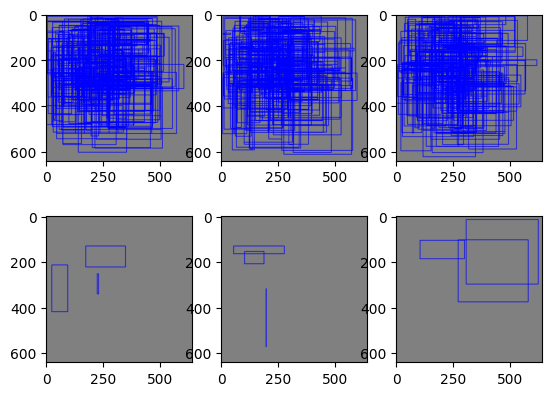

In [79]:

plt.figure()


stats = []

for si, pred in enumerate(preds):


    image = np.full_like(np.empty((640, 640, 3), np.uint8), 128)
    for box in pred:
        box = box.int()
        cv.rectangle(image, (box[0].item(), box[1].item()), (box[2].item(), box[3].item()), (0, 0, 255), 2)
    plt.subplot(2, batch_size, si + 1)
    plt.imshow(image)


    cls = torch.randint(0, 2, (3, 1))
    bbox = torch.randint(0, 320, (3, 4))
    bbox[..., 0] = bbox[..., 0] + bbox[..., 2] / 2
    bbox[..., 1] = bbox[..., 1] + bbox[..., 3] / 2
    tbox = xywh2xyxy(bbox)


    image = np.full_like(np.empty((640, 640, 3), np.uint8), 128)
    for box in tbox:
        cv.rectangle(image, (box[0].item(), box[1].item()), (box[2].item(), box[3].item()), (0, 0, 255), 2)
    plt.subplot(2, batch_size, si + batch_size + 1)
    plt.imshow(image)


    detections = pred.clone()
    labels = torch.cat((cls, tbox), 1)  # native-space labels

    iou = box_iou(labels[:, 1:], detections[:, :4])


    correct_bboxes = match_predictions(detections[:, 5], labels[:, 0], iou)

    print(correct_bboxes.shape)


    stats.append((correct_bboxes, pred[:, 4], pred[:, 5], cls.squeeze(-1)))


In [80]:
pred_classes = detections[:, 5]
true_classes = labels[:, 0]


iouv = torch.linspace(0.5, 0.95, 10)  # iou vector for mAP@0.5:0.95

# Dx10 matrix, where D - detections, 10 - IoU thresholds
correct = np.zeros((pred_classes.shape[0], iouv.shape[0])).astype(bool)
# LxD matrix where L - labels (rows), D - detections (columns)
correct_class = true_classes[:, None] == pred_classes
iou = iou * correct_class  # zero out the wrong classes
iou = iou.cpu().numpy()

# print(iou)

for i, threshold in enumerate(iouv.cpu().tolist()):
    matches = np.nonzero(iou >= threshold)  # IoU > threshold and classes match
    matches = np.array(matches).T
    
    if matches.shape[0]:
        print("=" * 10)
        print(matches)
        # print(matches.shape)
        if matches.shape[0] > 1:

            print(iou[matches[:, 0], matches[:, 1]])
            # print(iou[matches[:, 0], matches[:, 1]].argsort())
            print(iou[matches[:, 0], matches[:, 1]].argsort()[::-1])

            matches = matches[iou[matches[:, 0], matches[:, 1]].argsort()[::-1]]

            print(matches)
            # print(np.unique(matches[:, 1], return_index=True))
            print("-" * 10)
            matches = matches[np.unique(matches[:, 1], return_index=True)[1]]

            print(matches)
            # print(np.unique(matches[:, 0], return_index=True))
            matches = matches[np.unique(matches[:, 0], return_index=True)[1]]

            print(matches)
            print(i)

        correct[matches[:, 1].astype(int), i] = True
        # print(iou)
        print(correct[:, i]) 

[[ 0 19]
 [ 1 88]]
[0.5229503 0.7212459]
[1 0]
[[ 1 88]
 [ 0 19]]
----------
[[ 0 19]
 [ 1 88]]
[[ 0 19]
 [ 1 88]]
0
[False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False 

In [81]:
stats = [torch.cat(x, 0).cpu().numpy() for x in zip(*stats)]

In [82]:
def plot_pr_curve(px, py, ap, save_dir=Path('pr_curve.png'), names=(), on_plot=None):
    """Plots a precision-recall curve."""
    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)
    py = np.stack(py, axis=1)

    if 0 < len(names) < 21:  # display per-class legend if < 21 classes
        for i, y in enumerate(py.T):
            ax.plot(px, y, linewidth=1, label=f'{names[i]} {ap[i, 0]:.3f}')  # plot(recall, precision)
    else:
        ax.plot(px, py, linewidth=1, color='grey')  # plot(recall, precision)

    ax.plot(px, py.mean(1), linewidth=3, color='blue', label='all classes %.3f mAP@0.5' % ap[:, 0].mean())
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    ax.set_title('Precision-Recall Curve')
    fig.savefig(save_dir, dpi=250)
    plt.close(fig)
    if on_plot:
        on_plot(save_dir)

def plot_mc_curve(px, py, save_dir=Path('mc_curve.png'), names=(), 
                  xlabel='Confidence', ylabel='Metric', on_plot=None):
    """Plots a metric-confidence curve."""
    fig, ax = plt.subplots(1, 1, figsize=(9, 6), tight_layout=True)

    if 0 < len(names) < 21:  # display per-class legend if < 21 classes
        for i, y in enumerate(py):
            ax.plot(px, y, linewidth=1, label=f'{names[i]}')  # plot(confidence, metric)
    else:
        ax.plot(px, py.T, linewidth=1, color='grey')  # plot(confidence, metric)

    y = smooth(py.mean(0), 0.05)
    ax.plot(px, y, linewidth=3, color='blue', label=f'all classes {y.max():.2f} at {px[y.argmax()]:.3f}')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.04, 1), loc='upper left')
    ax.set_title(f'{ylabel}-Confidence Curve')
    fig.savefig(save_dir, dpi=250)
    plt.close(fig)
    if on_plot:
        on_plot(save_dir)


def compute_ap(recall, precision):

    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))

    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = 'interp'  # methods: 'continuous', 'interp'
    if method == 'interp':
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x-axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap, mpre, mrec

def smooth(y, f=0.05):
    """Box filter of fraction f."""
    nf = round(len(y) * f * 2) // 2 + 1  # number of filter elements (must be odd)
    p = np.ones(nf // 2)  # ones padding
    yp = np.concatenate((p * y[0], y, p * y[-1]), 0)  # y padded
    return np.convolve(yp, np.ones(nf) / nf, mode='valid')  # y-smoothed

    
def ap_per_class(tp, conf, pred_cls, target_cls, plot=False, on_plot=None, 
                 save_dir=Path(), names=(), eps=1e-16, prefix=''):

    # Sort by objectness
    i = np.argsort(-conf)

    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]


    print("置信度区间:", conf[0], "~", conf[-1])

    # Find unique classes
    unique_classes, nt = np.unique(target_cls, return_counts=True)
    nc = unique_classes.shape[0]  # number of classes, number of detections

    # Create Precision-Recall curve and compute AP for each class
    px, py = np.linspace(0, 1, 1000), []  # for plotting

    ap, p, r = np.zeros((nc, tp.shape[1])), np.zeros((nc, 1000)), np.zeros((nc, 1000))
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c

        n_l = nt[ci]  # number of labels
        n_p = i.sum()  # number of predictions

        print("该类样本真实量:", n_l)
        print("该类样本预测量:", n_p)
        # print(n_p)
        if n_p == 0 or n_l == 0:
            continue

        # Accumulate FPs and TPs
        fpc = (1 - tp[i]).cumsum(0)
        tpc = tp[i].cumsum(0)


        print("(最低置信度)该类tp:", tpc.shape, "不同IOU:", tpc[-1, :])
        print("(最低置信度)该类fp:", fpc.shape, "不同IOU:", fpc[-1, :])

        # Recall
        recall = tpc / (n_l + eps)  # recall curve
        r[ci] = np.interp(-px, -conf[i], recall[:, 0], left=0)  # negative x, xp because xp decreases

        print("(最低置信度)recall:", recall[-1, :].round(3))

        # Precision
        precision = tpc / (tpc + fpc)  # precision curve
        p[ci] = np.interp(-px, -conf[i], precision[:, 0], left=1)  # p at pr_score

        print("(最低置信度)precision:", precision[-1, :].round(3))

        print("mAP@不同IOU数量:", tp.shape[1])

        # AP from recall-precision curve
        for j in range(tp.shape[1]):
            ap[ci, j], mpre, mrec = compute_ap(recall[:, j], precision[:, j])
            if plot and j == 0:
                py.append(np.interp(px, mrec, mpre))  # precision at mAP@0.5

        print("-" * 100)
    # Compute F1 (harmonic mean of precision and recall)
    f1 = 2 * p * r / (p + r + eps)
    print("(mAP@IOU0.5) f1:", f1.shape)
    names = [v for k, v in names.items() if k in unique_classes]  # list: only classes that have data
    names = dict(enumerate(names))  # to dict
    print(names)

    if plot:
        plot_pr_curve(px, py, ap, save_dir / f'{prefix}PR_curve.png', names, on_plot=on_plot)
        plot_mc_curve(px, f1, save_dir / f'{prefix}F1_curve.png', names, ylabel='F1', on_plot=on_plot)
        plot_mc_curve(px, p, save_dir / f'{prefix}P_curve.png', names, ylabel='Precision', on_plot=on_plot)
        plot_mc_curve(px, r, save_dir / f'{prefix}R_curve.png', names, ylabel='Recall', on_plot=on_plot)

    i = smooth(f1.mean(0), 0.1).argmax()  # max F1 index
    p, r, f1 = p[:, i], r[:, i], f1[:, i]
    tp = (r * nt).round()  # true positives
    fp = (tp / (p + eps) - tp).round()  # false positives

    return tp, fp, p, r, f1, ap, unique_classes.astype(int)

tp, fp, p, r, f1, ap, _ = ap_per_class(*stats, names={0:"A", 1:"B"}, plot=False)


print("ap:", ap.round(4))
print("p:", p)
print("r:", r)


置信度区间: 0.9995122 ~ 2.4914742e-05
该类样本真实量: 5
该类样本预测量: 299
(最低置信度)该类tp: (299, 10) 不同IOU: [1 0 0 0 0 0 0 0 0 0]
(最低置信度)该类fp: (299, 10) 不同IOU: [298 299 299 299 299 299 299 299 299 299]
(最低置信度)recall: [0.2 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
(最低置信度)precision: [0.003 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
mAP@不同IOU数量: 10
----------------------------------------------------------------------------------------------------
该类样本真实量: 4
该类样本预测量: 301
(最低置信度)该类tp: (301, 10) 不同IOU: [1 1 1 1 1 0 0 0 0 0]
(最低置信度)该类fp: (301, 10) 不同IOU: [300 300 300 300 300 301 301 301 301 301]
(最低置信度)recall: [0.25 0.25 0.25 0.25 0.25 0.   0.   0.   0.   0.  ]
(最低置信度)precision: [0.003 0.003 0.003 0.003 0.003 0.    0.    0.    0.    0.   ]
mAP@不同IOU数量: 10
----------------------------------------------------------------------------------------------------
(mAP@IOU0.5) f1: (2, 1000)
{0: 'A', 1: 'B'}
ap: [[0.002  0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.0044 0.0044 0.0044 0.0044 0.